# Multi-Species Multi-Reaction model

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

zsh:1: no matches found: pybamm[plot,cite]
Note: you may need to restart the kernel to use updated packages.


## Model Equations

Here we briefly outline the models used for the open-circuit potential, kinetics, and solid phase transport used in the MSMR model, as described in Baker and Verbrugge (2018). The remaining physics is modelled differently depending on which options are selected. By default, the rest of the battery model is as described in Maquis et al. (2019). In the following we give equations for a single electrode.

### Thermodynamics
The MSMR model is developed by assuming that all electrochemical reactions at the electrode/electrolyte interface in a lithium insertion cell can be expressed in the form 
$$ \text{Li}^{+} + \text{e}^{-} + \text{H}_{j} \rightleftharpoons  (\text{Li--H})_{j}.$$
For each species $j$, a vacant host site $\text{H}_{j}$ can accommodate one lithium leading to a filled host site $(\text{Li--H})_{j}$. The OCV for this reaction is written as
$$ U_j = U_j^0 + \frac{\omega_j}{f}\log\left(\frac{X_j - x_j}{x_j}\right),$$
where $f = (RT)/F$, and $R$, $T$, and $F$ are the universal gas constant, temperature in Kelvin, and Faraday’s constant, respectively. Here $X_j$ represents the total fraction of available host sites which can be occupied by species $j$, $x_j$ is the fraction of filled sites occupied by species $j$, $U_j^0$ is a concentration independent standard electrode potential, and the $\omega_j$ is an unitless parameter that describes the level of disorder of the reaction represented by gallery $j$. 

The equation for each reaction can be inverted to give 
$$x_j = \frac{X_j}{1+\exp[f(U-U_j^0)/\omega_j]}.$$
The overall electrode state of charge is given by summing the fractional occupancies 
$$x = \sum_j x_j = \sum_j \frac{X_j}{1+\exp[f(U-U_j^0)/\omega_j]},$$
which is an explicit closed form expression for the inverse of the OCV. This is opposite to many battery models where one typically gives the OCV as an explicit function of the state of charge (or stoichiometry).

At a particle interface with the electrolyte, local equilibrium requires that 
$$U_j = U(x) \quad \forall j.$$

### Kinetics
The kinetics of the insertion reaction are given as
$$i_j = i_{0,j}[e^{(1-\alpha_j)f\eta} - e^{-\alpha_jf\eta}], \qquad i = \sum_j i_j,$$
where $i_j$ is the interfacial current associated with reaction $j$, $\alpha_j$ is the symmetry factor, $\eta$ is the overpotential, given by 
$$ \eta = \phi_s - \phi_e - U(x),$$
where $\phi_s$ and $\phi_e$ are the solid phase and electrolyte potentials, respectively, and $i_{0,j}$ is the exchange current density of reaction $j$, given by
$$i_{0,j} = i_{0,j}^{ref}(x_j)^{\omega_j\alpha_j}(X_j-x_j)^{\omega_j(1-\alpha_j)}(c_e/c_e^{ref})^{1-\alpha_j},$$
where $c_e$ is the electrolyte concentration.

### Solid phase transport
Within the MSMR framework, the flux within the particles is expressed in terms of gradient of the chemical potential
$$N = -c_{\text{T}}x\frac{D}{RT}\nabla \mu + x(N+N_{\text{H}}),$$
where $N$ is the flux of lithiated sites, $N_{\text{H}}$ is the flux of unlithiated sites, $c_{\text{T}}$ is the total concentration of lithiated and delithiated sites, and $D$ is a diffusion coefficient. Ignoring volumetric expansion during lithiation, the total flux of sites vanishes
$$N+N_{\text{H}}.$$ 
It can then be shown that 
$$N = c_{\text{T}}fDx(1-x)\frac{\text{d}U}{\text{d}x}\nabla x.$$

A mass balance in the solid phase then gives
$$\frac{\partial x}{\partial t} = -\nabla\cdot\left(x(1-x)fD\frac{\text{d}U}{\text{d}x}\nabla x\right),$$
which, for a radially symmetric spherical particle, must be solved subject to the boundary conditions
$$N\big\vert_{r=0} = 0, \quad N\big\vert_{r=R} = \frac{i}{F},$$
where $R$ is the particle radius. This must be supplemented with a suitable initial condition for the electrode state of charge.

Solution of this problem requires evaluate of the function $U(x)$ and the derivative $\text{d}U/\text{d}x$, but these functions cannot be explicitly integrated. This problem can be avoided by replacing the dependent variable $x$ with a new dependent variable $U$ subject to the transformation 
$$x = \sum_j \frac{X_j}{1+\exp[f(U-U_j^0)/\omega_j]}.$$
This gives the following equation for mass balance within the particles
$$\frac{\text{d}U}{\text{d}x}\frac{\partial U}{\partial t} = -\nabla\cdot\left(x(1-x)fD\nabla x\right),$$

which must be solved along with the transformed boundary and initial conditions.

## Parameterization of the MSMR model
The behaviour of MSMR model is characterised by the parameters $X_j$, $U^0_j$, $\omega_j$, $\alpha_j$, and $i_{0,j}^{ref}$. Let's take a look at their values in the example parameter set provided in PyBaMM. The thermodynamic parameter values are taken from Verbrugge et al. (2017) and correspond to a graphite negative electrode and NMC positive electrode. The remaining value are based on a parameterization of the LG M50 cell, from Chen et al. (2020).

We first load in the MSMR model and specify the number of reactions in each electrode

In [2]:
model = pybamm.lithium_ion.MSMR({"number of MSMR reactions": ("6", "4")})

Then we can inspect the parameter values

In [3]:
parameter_values = model.default_parameter_values

# Loop over domains
for domain in ["negative", "positive"]:
    print(f"{domain} electrode:")
    d = domain[0]
    # Loop over reactions
    N = int(parameter_values["Number of reactions in " + domain + " electrode"])
    for i in range(N):
        print(
            f"X_{d}_{i} = {parameter_values[f'X_{d}_{i}']}, "
            f"U0_{d}_{i} = {parameter_values[f'U0_{d}_{i}']}, "
            f"w_{d}_{i} = {parameter_values[f'w_{d}_{i}']}, "
            f"a_{d}_{i} = {parameter_values[f'a_{d}_{i}']} "
            f"j0_ref_{d}_{i} = {parameter_values[f'j0_ref_{d}_{i}']}"
        )

negative electrode:
X_n_0 = 0.43336, U0_n_0 = 0.08843, w_n_0 = 0.08611, a_n_0 = 0.5 j0_ref_n_0 = 2.7
X_n_1 = 0.23963, U0_n_1 = 0.12799, w_n_1 = 0.08009, a_n_1 = 0.5 j0_ref_n_1 = 2.7
X_n_2 = 0.15018, U0_n_2 = 0.14331, w_n_2 = 0.72469, a_n_2 = 0.5 j0_ref_n_2 = 2.7
X_n_3 = 0.05462, U0_n_3 = 0.16984, w_n_3 = 2.53277, a_n_3 = 0.5 j0_ref_n_3 = 2.7
X_n_4 = 0.06744, U0_n_4 = 0.21446, w_n_4 = 0.0947, a_n_4 = 0.5 j0_ref_n_4 = 2.7
X_n_5 = 0.05476, U0_n_5 = 0.36325, w_n_5 = 5.97354, a_n_5 = 0.5 j0_ref_n_5 = 2.7
positive electrode:
X_p_0 = 0.13442, U0_p_0 = 3.62274, w_p_0 = 0.9671, a_p_0 = 0.5 j0_ref_p_0 = 5
X_p_1 = 0.3246, U0_p_1 = 3.72645, w_p_1 = 1.39712, a_p_1 = 0.5 j0_ref_p_1 = 5
X_p_2 = 0.21118, U0_p_2 = 3.90575, w_p_2 = 3.505, a_p_2 = 0.5 j0_ref_p_2 = 5
X_p_3 = 0.3298, U0_p_3 = 4.22955, w_p_3 = 5.52757, a_p_3 = 1 j0_ref_p_3 = 1000000.0


We can plot the functional form of the open-circuit potential $U$, fractional occupancies $x_j$, and exchange current densities $i_{0,j}$ as a function of stoichiometry $x$

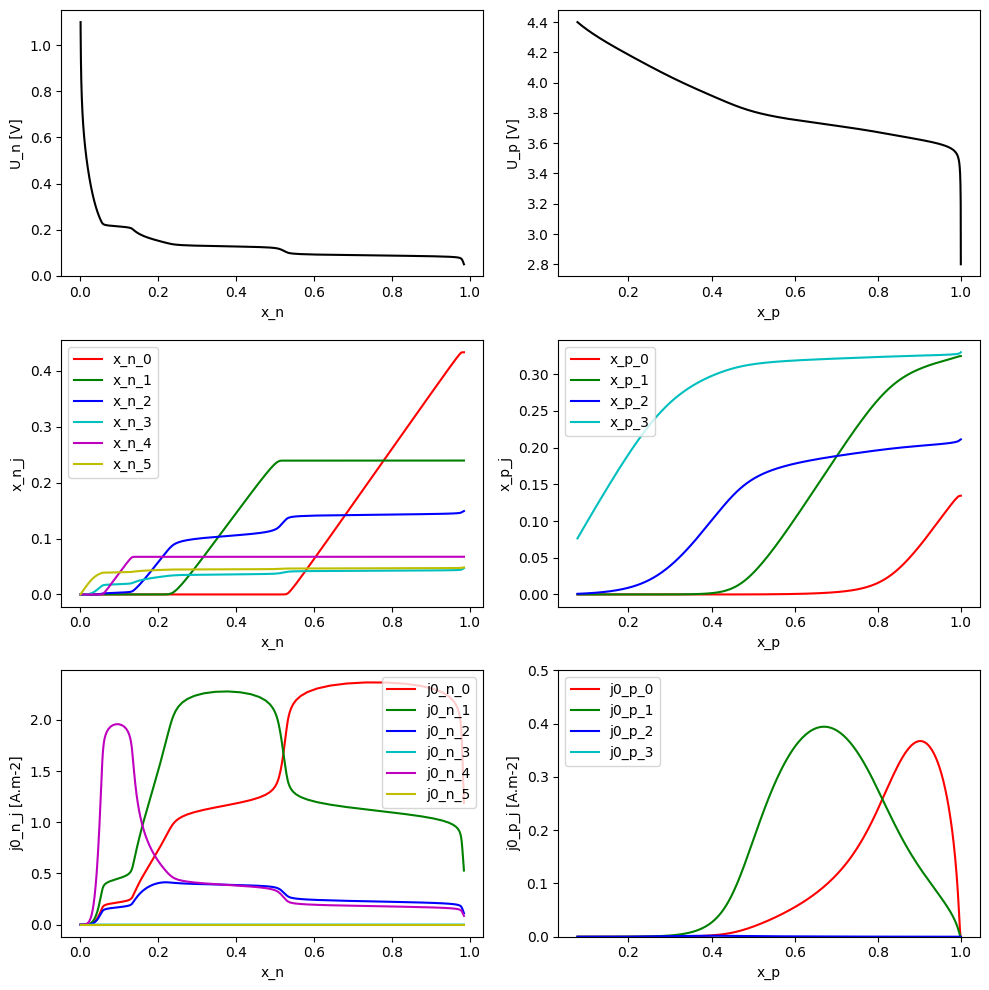

In [4]:
# get symbolic parameters
param = model.param
param_n = param.n.prim
param_p = param.p.prim

# set up ranges for plotting
U_n = pybamm.linspace(0.05, 1.1, 1000)
U_p = pybamm.linspace(2.8, 4.4, 1000)

# get reference electrolyte concentration and temperature
c_e = param.c_e_init
T = param.T_init

# set up figure
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
colors = ["r", "g", "b", "c", "m", "y"]

# sto vs potential
x_n = param_n.x(U_n)
x_p = param_p.x(U_p)
ax[0, 0].plot(parameter_values.evaluate(x_n), parameter_values.evaluate(U_n), "k-")
ax[0, 1].plot(parameter_values.evaluate(x_p), parameter_values.evaluate(U_p), "k-")
ax[0, 0].set_xlabel("x_n")
ax[0, 0].set_ylabel("U_n [V]")
ax[0, 1].set_xlabel("x_p")
ax[0, 1].set_ylabel("U_p [V]")

# fractional occupancy vs potential
for i in range(6):
    xj = param_n.x_j(U_n, i)
    ax[1, 0].plot(
        parameter_values.evaluate(x_n),
        parameter_values.evaluate(xj),
        color=colors[i],
        label=f"x_n_{i}",
    )
ax[1, 0].set_xlabel("x_n")
ax[1, 0].set_ylabel("x_n_j")
ax[1, 0].legend()
for i in range(4):
    xj = param_p.x_j(U_p, i)
    ax[1, 1].plot(
        parameter_values.evaluate(x_p),
        parameter_values.evaluate(xj),
        color=colors[i],
        label=f"x_p_{i}",
    )
ax[1, 1].set_xlabel("x_p")
ax[1, 1].set_ylabel("x_p_j")
ax[1, 1].legend()

# exchange current density vs potential
for i in range(6):
    xj = param_n.x_j(U_n, i)
    j0 = param_n.j0_j(c_e, U_n, T, i)
    ax[2, 0].plot(
        parameter_values.evaluate(x_n),
        parameter_values.evaluate(j0),
        color=colors[i],
        label=f"j0_n_{i}",
    )
ax[2, 0].set_xlabel("x_n")
ax[2, 0].set_ylabel("j0_n_j [A.m-2]")
ax[2, 0].legend()
for i in range(4):
    xj = param_p.x_j(U_p, i)
    j0 = param_p.j0_j(c_e, U_p, T, i)
    ax[2, 1].plot(
        parameter_values.evaluate(x_p),
        parameter_values.evaluate(j0),
        color=colors[i],
        label=f"j0_p_{i}",
    )
ax[2, 1].set_ylim([0, 0.5])
ax[2, 1].set_xlabel("x_p")
ax[2, 1].set_ylabel("j0_p_j [A.m-2]")
ax[2, 1].legend()

plt.tight_layout()

## Example solving MSMR using PyBaMM
Below we show how to set up and solve a CCCV experiment using the MSMR model in PyBaMM. We already created the model in the previous section, so we can go ahead and define our experiment, before creating and solving a simulation

In [5]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C for 1 hour or until 3 V",
            "Rest for 1 hour",
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until 10 mA",
            "Rest for 1 hour",
        ),
    ],
    period="10 seconds",
)
sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()

At t = 275.026 and h = 2.68649e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 275.028 and h = 4.19765e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Finally we can plot the results. In the MSMR model we can look at both the potential and stoichiometry as a function of position through the electrode and within the particle

In [6]:
sim.plot(
    [
        "Negative particle stoichiometry",
        "Positive particle stoichiometry",
        "X-averaged negative electrode open-circuit potential [V]",
        "X-averaged positive electrode open-circuit potential [V]",        
        "Negative particle potential [V]",
        "Positive particle potential [V]",
        "Current [A]",
        "Voltage [V]",
    ],
    variable_limits="tight",  # make axes tight to plot at each timestep
)

interactive(children=(FloatSlider(value=0.0, description='t', max=6.106530343899824, step=0.06106530343899824)…

We can also look at the individual reactions

In [7]:
xns = [f"Average x_n_{i}" for i in range(6)]  # negative electrode reactions: x_n_0, x_n_1, ..., x_n_5
xps = [f"Average x_p_{i}" for i in range(4)]  # positive electrode reactions: x_p_0, x_p_1, ..., x_p_3
sim.plot(
    [
        xns,
        xps,
        "Current [A]",
        "Negative electrode stoichiometry",
        "Positive electrode stoichiometry",
        "Voltage [V]",
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=6.106530343899824, step=0.06106530343899824)…

and plot how they sum to give the electrode stoichiometry 

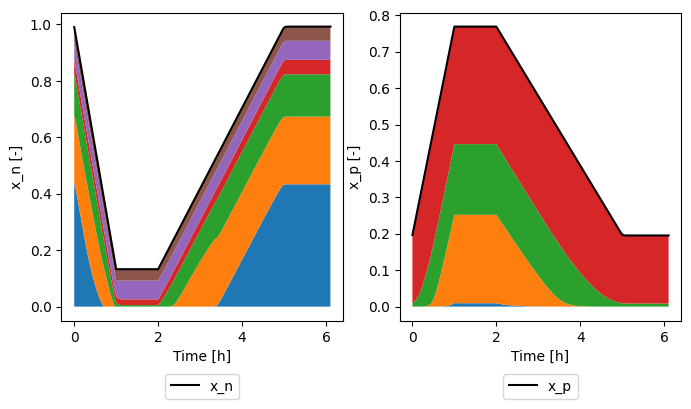

In [8]:
sol = sim.solution
time = sol["Time [h]"].data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(time, sol["Average negative particle stoichiometry"].data, "k-", label="x_n")
bottom = 0
for xn in xns:
    top = bottom + sol[xn].data
    ax[0].fill_between(time, bottom, top, label=xn[-4:])
    bottom = top
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("x_n [-]")
ax[0].legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3
)
ax[1].plot(time, sol["Average positive particle stoichiometry"].data, "k-", label="x_p")
bottom = 0
for xp in xps:
    top = bottom + sol[xp].data
    ax[1].fill_between(time, bottom, top, label=xp[-4:])
    bottom = top
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("x_p [-]")
ax[1].legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3
)

## References

The relevant papers for this notebook are:

In [9]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Daniel R Baker and Mark W Verbrugge. Multi-species, multi-reaction model for porous intercalation electrodes: part i. model formulation and a perturbation solution for low-scan-rate, linear-sweep voltammetry of a spinel lithium manganese oxide electrode. Journal of The Electrochemical Society, 165(16):A3952, 2018.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/pol